# Registration Lab
## Load the NIFTI images

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import rotate
from sklearn.metrics import mutual_info_score
from scipy.optimize import minimize
from skimage.metrics import structural_similarity, mean_squared_error

In [3]:
ct_file = nib.load("ct.nii")
mr_file1 = nib.load("mr1.nii")
mr_file2 = nib.load("mr2.nii")

In [4]:
print(ct_file.shape)
print(mr_file1.shape)
print(mr_file2.shape)

(271, 271, 221)
(164, 241, 241)
(165, 240, 241)


In [5]:
print(ct_file.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'?TR:0.000 TE:0.00'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 271 271 221   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 0.000000e+00
 1.000000e+00 1.000000e+00 3.879853e+04]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 4095
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 

In [6]:
ct_img = ct_file.get_fdata()
mr_img1 = mr_file1.get_fdata()
mr_img2 = mr_file2.get_fdata()
print(ct_img.shape)

(271, 271, 221)


(<AxesSubplot:>,
 (-0.5, 239.5, 164.5, -0.5))

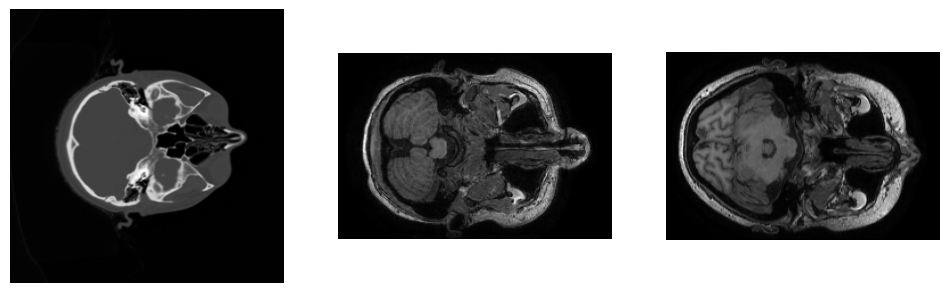

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(1,3,1), plt.imshow(ct_img[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,3,2), plt.imshow(mr_img1[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(mr_img2[:, :, 100], cmap='gray'), plt.axis('off')

## Functions
### Interpolation

In [8]:
def bilinear_interpolation(img, interpolation_points):
    """ Performs bilinear interpolation on a given image at all the coordinates.
    Parameters
    ----------
    image : ndarray
        The image on which to perform interpolation.
    interpolation_points : ndarray
        Contains the coordinates (x, y) of the points where the interpolation will be placed."""
    
    x = np.linspace(0, img.shape[1] - 1, img.shape[1])
    y = np.linspace(0, img.shape[0] - 1, img.shape[0])
    X, Y = np.meshgrid(x, y)
    original_points = np.column_stack((X.flatten(), Y.flatten()))
    interpolated_img = griddata(original_points, img.flatten(), interpolation_points, method='linear', fill_value=0)
    
    return interpolated_img

### Rotation

In [9]:
def rotate_transform(img, rot_angles=(0.5, 0)): 
    """Rotates an image to the given angles for registration algorithms.
    Parameters:
    - img: 2D array 
        img to be rotated
    - angle: tuple
        angles (in degrees) in x and y planes to be rotated
    Returns: rotated_img, 2D array
    """
    
    x_rot = np.array([[1, 0, 0], 
        [0, np.cos(rot_angles[0]), -np.sin(rot_angles[0])],
        [0, np.sin(rot_angles[0]), np.cos(rot_angles[0])]])
    y_rot = np.array([[np.cos(rot_angles[1]), 0, np.sin(rot_angles[1])], 
            [0, 1, 0], 
            [-np.sin(rot_angles[1]), 0, np.cos(rot_angles[1])]])
    
    x = np.linspace(0, img.shape[1] - 1, img.shape[1])
    y = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    trans_img = np.zeros(img.shape)
    
    x, y = np.meshgrid(x, y)
    
    original_points = np.column_stack((x.flatten(), y.flatten()))
    
    new_points = []
    for x, y in original_points:
        rotated_point = np.dot(x_rot, np.dot(y_rot, np.array([[x], [y], [1]])))
        new_points.append([np.float64(rotated_point[0]), np.float64(rotated_point[1])])  # Extract only the x and y coordinates
        
    trans_img = bilinear_interpolation(img, new_points)
    trans_img = np.reshape(trans_img, img.shape)
    
    return trans_img

In [10]:
rot_img = rotate_transform(mr_img1[:, :, 100], (0.25, 0.25))

(<AxesSubplot:>,
 (-0.5, 240.5, 163.5, -0.5))

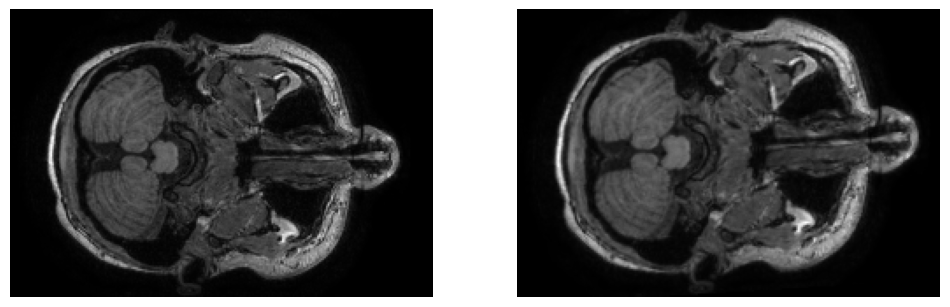

In [11]:
plt.figure(figsize=(12, 8))
mr_img1 = mr_img1 / np.max(mr_img1)
plt.subplot(1,2,1), plt.imshow(mr_img1[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(rot_img, cmap='gray'), plt.axis('off')

## Translation

In [12]:
def translate_transform(img, translate_dist=(5, 5)): 
    """Translates an image for registration algorithms.
    Parameters:
    - img: 2D array 
        img to be translated
    - translate_dist: tuple of shape (x_dist, y_dist)
        length (in pixels) along which x and y are going to be translated 
    Returns: trans_img, Translated img (2D array)
    """
    x = np.linspace(0, img.shape[1] - 1, img.shape[1])
    y = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    trans_img = np.zeros(img.shape)
    
    x_new = x + translate_dist[0]
    y_new = y + translate_dist[1]
    x_new, y_new = np.meshgrid(x_new, y_new)
    new_points = np.column_stack((x_new.flatten(), y_new.flatten()))
        
    trans_img = bilinear_interpolation(img, new_points)
    trans_img = np.reshape(trans_img, img.shape)
    
    return trans_img 

In [13]:
moved_img = translate_transform(mr_img1[:, :, 100], (25, 25))

(<AxesSubplot:>,
 (-0.5, 240.5, 163.5, -0.5))

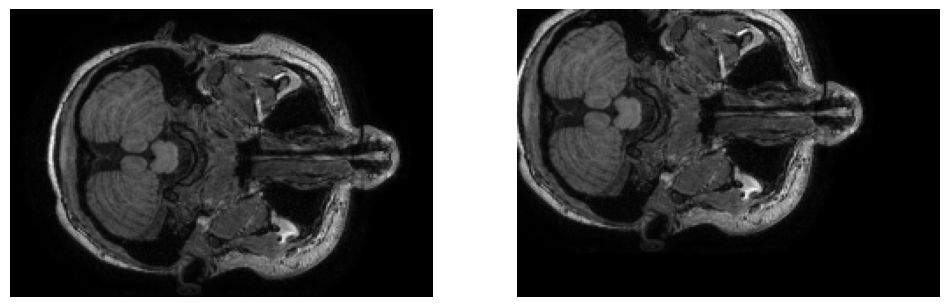

In [14]:
plt.figure(figsize=(12, 8))
mr_img1 = mr_img1 / np.max(mr_img1)
plt.subplot(1,2,1), plt.imshow(mr_img1[:, :, 100], cmap='gray'), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(moved_img, cmap='gray'), plt.axis('off')

## Metrics

In [17]:
mutual_information = mutual_info_score(mr_img1[:, :, 100].flatten(),moved_img.flatten())
print(f"Mutual Information: {mutual_information}") 

Mutual Information: 7.5343585414450835


c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


## Optimization

In [18]:
def apply_transform(img, parameters):
    """Apply translation and rotation according to parameters received. """
    trans_img = np.zeros(img.shape)
    if len(parameters)==4:
        trans_img = translate_transform(img, (parameters[0], parameters[1]))
        trans_img = rotate_transform(img, (parameters[2], parameters[3]))
        return trans_img
        
    else: 
        print("Error: not enough parameters provided. ")
        return 0

def neg_mutual_info(x):
    # x is the transformation parameters you want to optimize
    trans_img = apply_transform(img, x)  
    mi = mutual_info_score(trans_img.flatten(), img.flatten())
    
    return -mi  # Minimize the negative mutual information


## Example of reconstruction

In [31]:
img = mr_img1[:, :, 100] # load image 

trans_img = apply_transform(img, (2, 2, 0.25, 0.25)) # transform forward

# init parameters
random_state = np.random.RandomState(seed=42)
translation = random_state.uniform(0, img.shape[0], size=2)
rotation = random_state.uniform(0, 180, size=2)
initial_params = np.concatenate((translation, rotation))



### L-BFGS-B optimizer 

c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discr

(<AxesSubplot:title={'center':'recovered'}>,
 (-0.5, 240.5, 163.5, -0.5),
 Text(0.5, 1.0, 'recovered'))

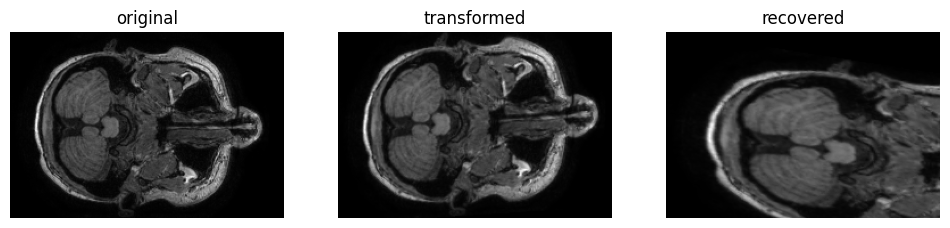

In [32]:
result = minimize(neg_mutual_info, initial_params, method='L-BFGS-B')
optimal_params = result.x

optimal_recovered_img = apply_transform(trans_img, optimal_params) # transform backward 

plt.figure(figsize=(12, 8))
plt.subplot(1,3,1), plt.imshow(img, cmap='gray'), plt.axis('off'), plt.title("original")
plt.subplot(1,3,2), plt.imshow(trans_img, cmap='gray'), plt.axis('off'), plt.title("transformed")
plt.subplot(1,3,3), plt.imshow(optimal_recovered_img, cmap='gray'), plt.axis('off'), plt.title("recovered")

In [33]:
def evaluate_registration(img, trans_img, optimal_recovered_img):

    img = img / np.max(img)
    trans_img = trans_img / np.max(trans_img)
    optimal_recovered_img = optimal_recovered_img / np.max(optimal_recovered_img)


    mse_trans = mean_squared_error(img, trans_img)
    mse_recovered = mean_squared_error(img, optimal_recovered_img)

    ssim_trans = structural_similarity(img, trans_img)
    ssim_recovered = structural_similarity(img, optimal_recovered_img)

    print("MSE transformed:", mse_trans, "MSE recovered:", mse_recovered)
    print("SSIM transformed:", ssim_trans, "SSIM transformed:", ssim_recovered)
    
evaluate_registration(img, trans_img, optimal_recovered_img)

MSE transformed: 0.021275491508785657 MSE recovered: 0.04094041004915808
SSIM transformed: 0.5678352220166872 SSIM transformed: 0.34897622244019905


### Powell optimizer 

c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discr

(<AxesSubplot:title={'center':'recovered'}>,
 (-0.5, 240.5, 163.5, -0.5),
 Text(0.5, 1.0, 'recovered'))

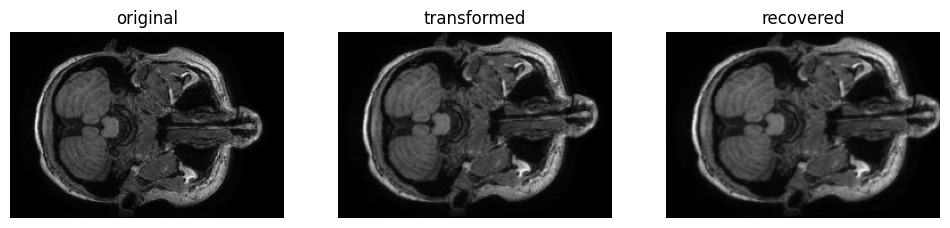

In [23]:
result = minimize(neg_mutual_info, initial_params, method='Powell', options={"disp":False})  
optimal_params = result.x

optimal_recovered_img = apply_transform(trans_img, optimal_params) # transform backward 

plt.figure(figsize=(12, 8))
plt.subplot(1,3,1), plt.imshow(img, cmap='gray'), plt.axis('off'), plt.title("original")
plt.subplot(1,3,2), plt.imshow(trans_img, cmap='gray'), plt.axis('off'), plt.title("transformed")
plt.subplot(1,3,3), plt.imshow(optimal_recovered_img, cmap='gray'), plt.axis('off'), plt.title("recovered")

In [30]:
evaluate_registration(img, trans_img, optimal_recovered_img)

MSE transformed: 0.021275491508785657 MSE recovered: 0.031684412879004004
SSIM transformed: 0.5678352220166872 SSIM transformed: 0.45574005915049
